Image based approach: doesn't seem to work. Again this is probably due to the signal-to-noise ratio. Hence the need to use transfer learning.

Install dependencies

In [4]:
import sys
!{sys.executable} -m pip install face_recognition

     |████████████████████████████████| 100.2MB 249kB/s  eta 0:00:01
     |████████████████████████████████| 3.2MB 49.5MB/s eta 0:00:01
     |████████████████████████████████| 92kB 23.1MB/s eta 0:00:01
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566176 sha256=9b3eb3a1b5ce8851d80b27ba059707ea3457b4a4d0dba17d3f6ca4b1f0688463
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
  Created wheel for dlib: filename=dlib-19.19.0-cp36-cp36m-linux_x86_64.whl size=3497780 sha256=be845c20cbc492c28907c5fc03e0b2f2c82091797bf14ce731a673f4ff42a93c
  Stored in directory: /root/.cache/pip/wheels/96/ac/11/8aadec62cb4fb5b264a9b1b042caf415de9a75f5e165d79a51
Successfully built face-recognition-models dlib
You should consider upgrading via the 'pip install --upgrade pip' command.


Dataset

In [5]:
import os
import time
import numpy as np
import face_recognition
from skimage.transform import resize
from skimage.util import pad

%matplotlib inline
import matplotlib.pyplot as plt


LABELS = ['22q11','Angelman','Apert','CDL','Down','FragileX','Marfan','Progeria','Sotos','TreacherCollins','Turner','Williams']
IMAGE_PATCH_SIZE = 256
EXTRA_PAD = 32

#LABELS.remove('CDL')


def load_dataset_patches(setPath):
    X = []
    Y = []

    for label in LABELS:
            
        directory = os.path.join(setPath,label)
        for f in os.listdir(directory):
            path = os.path.join(directory,f)
            
            if os.path.isfile(path) and f != 'desktop.ini':
                
                # Extract landmarks
                image = face_recognition.load_image_file(path)
                face_landmarks_list = face_recognition.face_landmarks(image)

                # Process faces
                for landmarks in face_landmarks_list:
                    
                    # find dimensions
                    top = image.shape[0]
                    bottom = 0
                    left = image.shape[1]
                    right = 0
                    
                    for featureType in landmarks.keys():
                        for point in landmarks[featureType]:
                            (x,y) = point
                            
                            if x < left:
                                left = x
                            if x > right:
                                right = x
                            if y < top:
                                top = y
                            if y > bottom:
                                bottom = y
                                
                    top = top - EXTRA_PAD if top - EXTRA_PAD >= 0 else 0
                    bottom = bottom + EXTRA_PAD if bottom + EXTRA_PAD < image.shape[0] else image.shape[0] - 1
                    left = left - EXTRA_PAD if left - EXTRA_PAD >= 0 else 0
                    right = right + EXTRA_PAD if right + EXTRA_PAD < image.shape[1] else image.shape[1] - 1
                    
                    height = bottom - top
                    width = right - left
                    
                    if height > width:
                        # fix height
                        diff = height - width
                        bottom = bottom - diff
                        
                    elif height < width:
                        # fix width
                        diff = width - height
                        right = right - diff
                            
                    
                    # extract patch from image
                    img_patch = image[top:bottom,left:right,:]
                    img_patch_resized = resize(img_patch,(IMAGE_PATCH_SIZE,IMAGE_PATCH_SIZE,3))

                    X.append(img_patch_resized)
                    Y.append(label)
                    
    # pack into numpy structure
    X_pack = np.zeros([len(X),IMAGE_PATCH_SIZE,IMAGE_PATCH_SIZE,3])
    for i in range(0,len(X)):
        X_pack[i,:,:] = X[i]
    Y_pack = np.array(Y)
    
    return X_pack, Y_pack

In [6]:
X_test, y_test = load_dataset_patches('./data/raw/Test')
print(X_test.shape)
print(y_test.shape)

(312, 256, 256, 3)
(312,)


In [7]:
X_val, y_val = load_dataset_patches('./data/raw/Validate')
print(X_val.shape)
print(y_val.shape)

(281, 256, 256, 3)
(281,)


In [8]:
X_train, y_train = load_dataset_patches('./data/raw/Train')
print(X_train.shape)
print(y_train.shape)

(1023, 256, 256, 3)
(1023,)


In [9]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y_train = encoder.fit_transform(y_train)
Y_test = encoder.transform(y_test)
Y_val = encoder.transform(y_val)

print(Y_train.shape)
print(Y_test.shape)

(1023, 12)
(312, 12)


Model

In [14]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_PATCH_SIZE,IMAGE_PATCH_SIZE,3)))
model.add(Conv2D(16, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (5,5), activation='relu'))
model.add(Conv2D(32, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5,5), activation='relu'))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 252, 252, 16)      1216      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 248, 248, 16)      6416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 120, 120, 32)      12832     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 116, 116, 32)      25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 54, 54, 64)       

Train

In [15]:
history = model.fit(X_train, Y_train, batch_size=1, epochs=15, shuffle=True, validation_data=(X_val,Y_val))
print(history)

Train on 1023 samples, validate on 281 samples
Epoch 1/15
1023/1023 [==============================] - 223s 218ms/step - loss: 2.2639 - accuracy: 0.1241 - val_loss: 2.2408 - val_accuracy: 0.0463
Epoch 2/15
1023/1023 [==============================] - 223s 218ms/step - loss: 2.2294 - accuracy: 0.1222 - val_loss: 2.3016 - val_accuracy: 0.0819
Epoch 3/15
1023/1023 [==============================] - 225s 220ms/step - loss: 2.2272 - accuracy: 0.1515 - val_loss: 2.3311 - val_accuracy: 0.0463
Epoch 4/15
1023/1023 [==============================] - 222s 217ms/step - loss: 2.2230 - accuracy: 0.1388 - val_loss: 2.3385 - val_accuracy: 0.0819
Epoch 5/15
1023/1023 [==============================] - 223s 218ms/step - loss: 2.2263 - accuracy: 0.1417 - val_loss: 2.3004 - val_accuracy: 0.0747
Epoch 6/15
1023/1023 [==============================] - 224s 219ms/step - loss: 2.2225 - accuracy: 0.1486 - val_loss: 2.3014 - val_accuracy: 0.0747
Epoch 7/15
1023/1023 [==============================] - 223s 218m

KeyboardInterrupt: 

Evaluate

In [16]:
score = model.evaluate(X_train, Y_train, batch_size=32, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

1023/1023 [==============================] - 19s 18ms/step
Train loss: 2.2049567169224877
Train accuracy: 0.15738025307655334


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

Y_pred = model.predict(X_train)
y_pred = encoder.inverse_transform(Y_pred)

conf = confusion_matrix(y_train, y_pred)

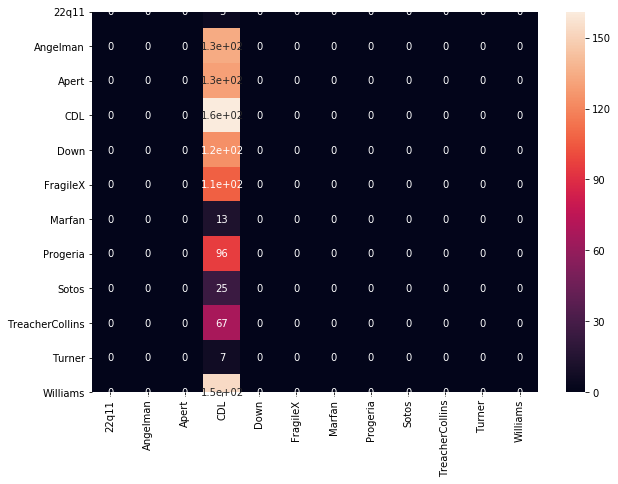

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [19]:
score = model.evaluate(X_val, Y_val, batch_size=32, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

281/281 [==============================] - 5s 18ms/step
Validation loss: 2.31744336148598
Validation accuracy: 0.08185053616762161


In [20]:
score = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

312/312 [==============================] - 6s 18ms/step
Test loss: 2.197005171042222
Test accuracy: 0.15064102411270142


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

Y_pred = model.predict(X_test)
y_pred = encoder.inverse_transform(Y_pred)

conf = confusion_matrix(y_test, y_pred)

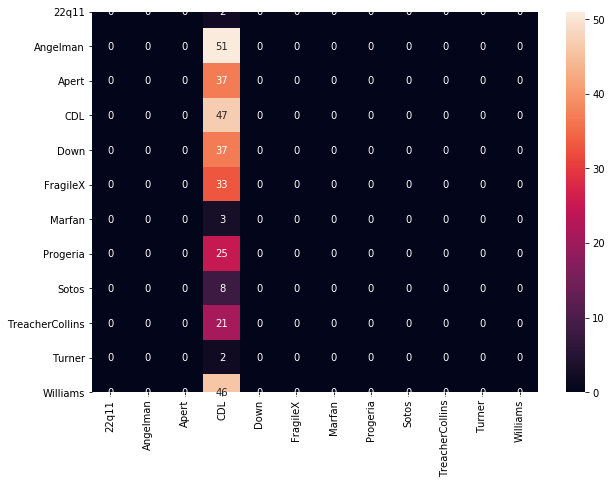

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Save

In [23]:
import time

save_dir = './models'
model_name = 'image-classifier-{}.h5'.format(int(time.time()))

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save_weights(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./models/image-classifier-1585760020.h5 
